In [1]:
import os
import time
import pyvista as pv
from pyvirtualdisplay import Display
import vtk
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
%matplotlib inline
import matplotlib.pyplot as plt
pv.set_plot_theme("document")
import time
import optax
from jax.scipy.sparse.linalg import cg

np.bool = np.bool_
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# XLA_PYTHON_CLIENT_MEM_FRACTION=.90

In [2]:
'''
Load mesh information from .k file in LS-DYNA input format

Return node positions, node birth times, element nodes,
element birth times, surfaces, and surface birth times.
'''
def load_inputfile(filename='data/0.k'):
    nodes = []
    node_sets = {}
    elements = []
    birth_list_element = []
    birth_list_node = []

    with open(filename) as f:
        while True:
            line = next(f)
            if not line.split():
                continue
            if line.split()[0] == '*NODE':
                first = True
                while True:
                    line = next(f)
                    if line[0] == '*':
                        break
                    if line[0] == '$':
                        continue
                    text = line.split()
                    if first:
                        node_base = int(text[0])
                        first = False
                    nodes.append([float(text[1]),float(text[2]),float(text[3])])
            if line.split()[0] == '*END':
                break  
    birth_list_node = [-1 for _ in range(len(nodes))]
    with open(filename) as f:
        line = next(f)
        while True:
            if not line.split():
                line = next(f)
                continue
            elif line.split()[0] == '*SET_NODE_LIST':
                line = next(f)
                line = next(f)
                key = int(line.split()[0])
                node_list = []
                while True:
                    line = next(f)
                    if line[0] == '*':
                        break
                    if line[0] == '$':
                        continue
                    for text in line.split():
                        node_list.append(int(text)-node_base)
                node_sets[key] = node_list
            elif line.split()[0] == '*END':
                break
            else:
                line = next(f)
    with open(filename) as f:
        while True:
            line = next(f)
            if not line.split():
                continue
            if line.split()[0] == '*ELEMENT_SOLID':
                first = True
                while True:
                    line = next(f)
                    if line[0] == '*':
                        break
                    if line[0] == '$':
                        continue
                    text = line.split()
                    if first:
                        element_base = int(text[0])
                        first = False
                    elements.append([int(text[2])-node_base, int(text[3])-node_base, int(text[4])-node_base, int(text[5])-node_base,
                                     int(text[6])-node_base, int(text[7])-node_base, int(text[8])-node_base, int(text[9])-node_base])
            if line.split()[0] == '*END':
                break
    birth_list_element = [-1.0]*len(elements)
    with open(filename) as f:
        while True:
            line = next(f)
            if not line.split():
                continue
            if line.split()[0] == '*DEFINE_CURVE':
                while True:
                    line = next(f)
                    if line[0] == '*':
                        break
                    if line[0] == '$':
                        continue
                    text = line.split()
                    birth_list_element[int(float(text[1]))-element_base] = float(text[0])
            if line.split()[0] == '*END':
                break
    for element, birth_element in zip(elements, birth_list_element):
        if birth_element < 0:
            continue
        for node in element:
            if (birth_list_node[node] > birth_element or 
                                        birth_list_node[node] < 0):
                                    birth_list_node[node] = birth_element
    
    # create element surface for node ids
    element_surface = np.zeros((len(elements), 6, 4), dtype=np.int32)
    for ind, element in enumerate(elements):
#         element_surface[ind, 0, :] = [element[0], element[1], element[2],element[3]]
#         element_surface[ind, 1, :] = [element[4], element[5], element[6],element[7]]
#         element_surface[ind, 2, :] = [element[0], element[3], element[7],element[4]]
#         element_surface[ind, 3, :] = [element[1], element[2], element[6],element[5]]
#         element_surface[ind, 4, :] = [element[0], element[1], element[5],element[4]]
#         element_surface[ind, 5, :] = [element[3], element[2], element[6],element[7]]
        element_surface[ind, 0, :] = [element[4], element[5], element[6],element[7]]
        element_surface[ind, 1, :] = [element[0], element[1], element[2],element[3]]
        element_surface[ind, 2, :] = [element[0], element[1], element[5],element[4]]
        element_surface[ind, 3, :] = [element[3], element[2], element[6],element[7]]
        element_surface[ind, 4, :] = [element[0], element[3], element[7],element[4]]
        element_surface[ind, 5, :] = [element[1], element[2], element[6],element[5]]

    # create element surface neighbors 
    def match_surface(ind, s_ind):
        for surf_ind, surf in enumerate(element_surface[ind]):
            for s_surf in element_surface[s_ind]:
                if set(surf) == set(s_surf):
                    return surf_ind
        else:
            return -1

    element_surface_neighbor = np.ones((len(elements), 6), dtype=np.int32) * -1
    for ind, element in enumerate(elements):
        for s_ind, s_element in enumerate(elements):
            if any(node in element for node in s_element) and ind != s_ind:
                surf_ind = match_surface(ind, s_ind)
                if surf_ind != -1:
                    element_surface_neighbor[ind, surf_ind] = s_ind

    # create element surface birth
    element_surface_birth = np.zeros((len(elements), 6, 2), dtype=float)
    for ele_ind, element_surface_nei in enumerate(element_surface_neighbor):
        for sur_ind, neighbor_ind in enumerate(element_surface_nei):
            if neighbor_ind == -1:
                birth = birth_list_element[ele_ind]
                death = 1.0e6
            else:
                birth = min(birth_list_element[ele_ind], birth_list_element[neighbor_ind])
                death = max(birth_list_element[ele_ind], birth_list_element[neighbor_ind])
            element_surface_birth[ele_ind, sur_ind] = [birth, death]
            
    return nodes, birth_list_node, elements, birth_list_element, element_surface, element_surface_birth

def load_toolpath(filename = 'data/toolpath_c.crs', dt = 0.02):
    toolpath_raw=pd.read_table(filename, delimiter=r"\s+",header=None, names=['time','x','y','z','state'])
    toolpath=[]
    state=[]
    ctime=0.0
    ind=0
    endTime = float(toolpath_raw.tail(1)['time'])
    while(ctime<=endTime):
        while(ctime>=toolpath_raw['time'][ind+1]):
            ind=ind+1
        X=toolpath_raw['x'][ind]+(toolpath_raw['x'][ind+1]-toolpath_raw['x'][ind])*(
            ctime-toolpath_raw['time'][ind])/(toolpath_raw['time'][ind+1]-toolpath_raw['time'][ind])
        Y=toolpath_raw['y'][ind]+(toolpath_raw['y'][ind+1]-toolpath_raw['y'][ind])*(
            ctime-toolpath_raw['time'][ind])/(toolpath_raw['time'][ind+1]-toolpath_raw['time'][ind])
        Z=toolpath_raw['z'][ind]+(toolpath_raw['z'][ind+1]-toolpath_raw['z'][ind])*(
            ctime-toolpath_raw['time'][ind])/(toolpath_raw['time'][ind+1]-toolpath_raw['time'][ind])
        toolpath.append([X,Y,Z])
        state.append(toolpath_raw['state'][ind+1])
        ctime = ctime + dt
#     # add 10s time to allow it to cool down at the end
#     for  _ in range(int(10.0/dt)):
#         toolpath.append([X,Y,Z])
#         state.append(0)
#     endTime = endTime + 10.0
    return toolpath, state, endTime

def shape_fnc_element(parCoord):
    chsi = parCoord[0]
    eta = parCoord[1]
    zeta = parCoord[2]
    N =  0.125 * jnp.stack([(1.0 - chsi)*(1.0 - eta)*(1.0 - zeta),(1.0 + chsi)*(1.0 - eta)*(1.0 - zeta),
                           (1.0 + chsi)*(1.0 + eta)*(1.0 - zeta), (1.0 - chsi)*(1.0 + eta)*(1.0 - zeta),
                           (1.0 - chsi)*(1.0 - eta)*(1.0 + zeta), (1.0 + chsi)*(1.0 - eta)*(1.0 + zeta),
                           (1.0 + chsi)*(1.0 + eta)*(1.0 + zeta), (1.0 - chsi)*(1.0 + eta)*(1.0 + zeta)])
    return N
    
def derivate_shape_fnc_element(parCoord):
    oneMinusChsi = 1.0 - parCoord[0]
    onePlusChsi  = 1.0 + parCoord[0]
    oneMinusEta  = 1.0 - parCoord[1]
    onePlusEta   = 1.0 + parCoord[1]
    oneMinusZeta = 1.0 - parCoord[2]
    onePlusZeta  = 1.0 + parCoord[2]
    B = 0.1250 * jnp.array([[-oneMinusEta * oneMinusZeta, oneMinusEta * oneMinusZeta, 
                                onePlusEta * oneMinusZeta, -onePlusEta * oneMinusZeta, 
                                -oneMinusEta * onePlusZeta, oneMinusEta * onePlusZeta, 
                                onePlusEta * onePlusZeta, -onePlusEta * onePlusZeta],
                              [-oneMinusChsi * oneMinusZeta, -onePlusChsi * oneMinusZeta, 
                               onePlusChsi * oneMinusZeta, oneMinusChsi * oneMinusZeta, 
                               -oneMinusChsi * onePlusZeta, -onePlusChsi * onePlusZeta, 
                               onePlusChsi * onePlusZeta, oneMinusChsi * onePlusZeta],
                               [-oneMinusChsi * oneMinusEta, -onePlusChsi * oneMinusEta, 
                                -onePlusChsi * onePlusEta, -oneMinusChsi * onePlusEta, 
                                oneMinusChsi * oneMinusEta, onePlusChsi * oneMinusEta, 
                                onePlusChsi * onePlusEta, oneMinusChsi * onePlusEta]])
    return B

def shape_fnc_surface(parCoord):
    N = jnp.zeros((4))
    chsi = parCoord[0]
    eta  = parCoord[1]
    N = 0.25 * jnp.array([(1-chsi)*(1-eta), (1+chsi)*(1-eta), (1+chsi)*(1+eta), (1-chsi)*(1+eta)])
    return N

def derivate_shape_fnc_surface(parCoord):
    oneMinusChsi = 1.0 - parCoord[0]
    onePlusChsi  = 1.0 + parCoord[0]
    oneMinusEta  = 1.0 - parCoord[1]
    onePlusEta   = 1.0 + parCoord[1]
    B = 0.25 * jnp.array([[-oneMinusEta, oneMinusEta, onePlusEta, -onePlusEta], 
                         [-oneMinusChsi, -onePlusChsi, onePlusChsi, oneMinusChsi]])
    return B

def surface_jacobian(nodes, surfaces):
    nodes_pos = nodes[surfaces]
    mapped_surf_nodes_pos = jnp.zeros([nodes_pos.shape[0],4,2])
    u = nodes_pos[:,1,:] - nodes_pos[:,0,:]
    v = nodes_pos[:,2,:] - nodes_pos[:,1,:]
    w = nodes_pos[:,3,:] - nodes_pos[:,0,:]
    l1 = jnp.linalg.norm(u,axis=1)
    l2 = jnp.linalg.norm(v,axis=1)
    l4 = jnp.linalg.norm(w,axis=1)
    cos12 = (u[:,0]*v[:,0] + u[:,1]*v[:,1] + u[:,2]*v[:,2])/(l1*l2)
    cos14 = (u[:,0]*w[:,0] + u[:,1]*w[:,1] + u[:,2]*w[:,2])/(l1*l4)
    sin12 = jnp.sqrt(1.0 - cos12*cos12)
    sin14 = jnp.sqrt(1.0 - cos14*cos14)
    mapped_surf_nodes_pos = jnp.zeros([nodes_pos.shape[0],4,2]).at[:,1,0].set(l1).at[:,2,0].set(l1 + l2*cos12) \
                                    .at[:,2,1].set(l2*sin12).at[:,3,0].set(l4*cos14).at[:,3,1].set(l4*sin14)

    Jac = jnp.matmul(Bip_sur, mapped_surf_nodes_pos[:,jnp.newaxis,:,:].repeat(4,axis=1))
    surf_detJac = jnp.linalg.det(Jac)
    return surf_detJac

Number of nodes: 350
Number of elements: 176
Number of surfaces: 390
Number of time-steps: 1501


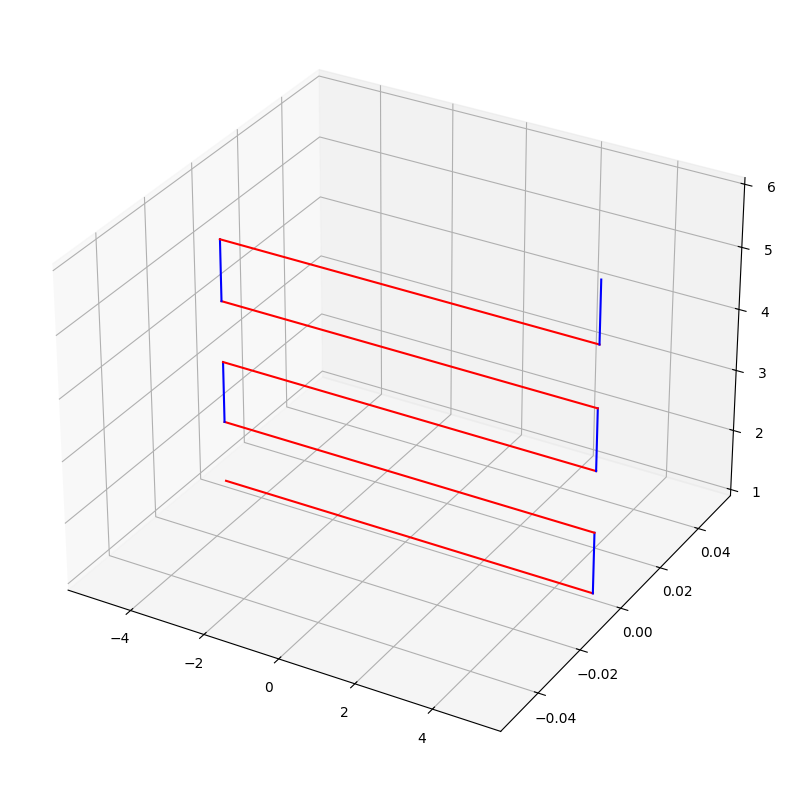

In [3]:
Load_data = True # always True I think
dt = 0.01
# dt = 0.009521608652924079
# dt = 0.001018131539532673
# obtain from modified preprocessor

data_dir = 'preprocessed_10x5'
toolpath_name = '10x5_toolpath.crs'

if Load_data:
    elements = jnp.load(f'{data_dir}/elements.npy')#.tolist()
    nodes = jnp.load(f'{data_dir}/nodes.npy')#.tolist()
    surfaces = jnp.load(f'{data_dir}/surface.npy')
    node_birth = jnp.load(f'{data_dir}/node_birth.npy')#.tolist()
    element_birth = jnp.load(f'{data_dir}/element_birth.npy')#.tolist()
    surface_birth = jnp.load(f'{data_dir}/surface_birth.npy')
    surface_xy = jnp.load(f'{data_dir}/surface_xy.npy')#.tolist()
    surface_flux = jnp.load(f'{data_dir}/surface_flux.npy')
#     elements = jnp.load('data_fine/elements.npy')#.tolist()
#     nodes = jnp.load('data_fine/nodes.npy')#.tolist()
#     surfaces = jnp.load('data_fine/surface.npy')
#     node_birth = jnp.load('data_fine/node_birth.npy')#.tolist()
#     element_birth = jnp.load('data_fine/element_birth.npy')#.tolist()
#     surface_birth = jnp.load('data_fine/surface_birth.npy')
    
toolpath, state, endTime = load_toolpath(filename=toolpath_name, dt = dt)

parCoords_element = jnp.array([[-1.0,-1.0,-1.0],[1.0,-1.0,-1.0],[1.0, 1.0,-1.0],[-1.0, 1.0,-1.0],
             [-1.0,-1.0,1.0],[1.0,-1.0, 1.0], [ 1.0,1.0,1.0],[-1.0, 1.0,1.0]]) * 0.5773502692
parCoords_surface = jnp.array([[-1.0,-1.0],[-1.0, 1.0],[1.0,-1.0],[1.0,1.0]])* 0.5773502692

Nip_ele = np.array([shape_fnc_element(parCoord) for parCoord in parCoords_element]) #[:,:,jnp.newaxis]
Bip_ele = np.array([derivate_shape_fnc_element(parCoord) for parCoord in parCoords_element])
Nip_sur = np.array([shape_fnc_surface(parCoord) for parCoord in parCoords_surface])
Bip_sur = np.array([derivate_shape_fnc_surface(parCoord) for parCoord in parCoords_surface])
surf_detJacs = surface_jacobian(nodes, surfaces)

print("Number of nodes: {}".format(len(nodes)))
print("Number of elements: {}".format(len(elements)))
print("Number of surfaces: {}".format(len(surfaces)))
print("Number of time-steps: {}".format(len(toolpath)))

toolpath_np = np.loadtxt(f'./{toolpath_name}')
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
for i in range(toolpath_np.shape[0]-1):
    ax.plot(toolpath_np[i:i+2, 1], 
            toolpath_np[i:i+2, 2], 
            toolpath_np[i:i+2, 3], 
            color='red' if toolpath_np[i+1,4]==1 else 'blue')
fig.tight_layout()
plt.show()

In [4]:
# Thermal functions
def update_birth(real_time):
    active_element_inds = (element_birth<=real_time)
    active_node_inds = (node_birth<=real_time)
    active_surface_inds = (surface_birth[:,0]<=real_time)*(surface_birth[:,1]>real_time)
    
#     return active_element_inds.reshape(-1, 1), active_node_inds.reshape(-1, 1), active_surface_inds.reshape(-1, 1)
    return active_element_inds, active_node_inds, active_surface_inds

def clear_vectors(num_nodes):
    m_vec = jnp.zeros(num_nodes)
    rhs = jnp.zeros(num_nodes)
    return m_vec, rhs
        
def time_integrate(temperature, rhs, m_vec, active_node_inds):   
    temperature = temperature.at[active_node_inds].add(dt * rhs[active_node_inds] / m_vec[active_node_inds]).at[bot_nodes].set(300)
    return temperature            

@jax.jit
def calc_cp(element, temperature):
    temperature_nodes = temperature[element]
    theta_ip = jnp.matmul(Nip_element, temperature_nodes)
    cp_el = jnp.where((theta_ip > solidus) & (theta_ip < liquidus), cp_val + latent, cp_val)
    return cp_el
    
@jax.jit
def calc_mass_stiff(element, cp, cond, temperature):
    nodes_pos = nodes[element] # (8, 3)
    temperature_nodes = temperature[element] # (8, )
    Jac = jnp.matmul(Bip_element, nodes_pos) # (8, 3, 3)
    detJac = jnp.linalg.det(Jac) # (8, )
    iJac = jnp.linalg.inv(Jac) # (8, 3, 3)  
    gradN = jnp.matmul(iJac, Bip_element) # (8,3,3) @ (8,3,8) -> (8,3,8)
    gradN_T = jnp.transpose(gradN, axes=(0,2,1)) # (8, 8, 3)

    mass = (density * cp * detJac)[:, jnp.newaxis] * jnp.sum(Nip_ele[:,:,jnp.newaxis]@Nip_ele[:,jnp.newaxis,:], axis= 0)
    lump_mass= jnp.sum(mass,axis=1)
    stiffness = jnp.sum((cond * detJac)[:, jnp.newaxis] * jnp.matmul(gradN_T, gradN), axis=0)
    stiff_temp = jnp.matmul(stiffness, temperature_nodes)
    return lump_mass, stiff_temp
    
def update_mvec_stiffness(m_vec, rhs, cps, elements, temperature, active_element_inds, active_node_inds):
    lump_mass, stiff_temp = jax.vmap(calc_mass_stiff, in_axes=(0, 0, 0, None))(elements, cps, conds_init, temperature)    
    lump_mass = lump_mass * active_element_inds[:,None]
    stiff_temp = stiff_temp * active_element_inds[:,None]
    m_vec = m_vec.at[elements].add(lump_mass)
    rhs = rhs.at[elements].add(-stiff_temp)
    return m_vec, rhs

@jax.jit
def calc_flux(surface, surf_detJac, surface_xy, surface_flux, t, temperature, base_power, controller):
    ip_pos = jnp.matmul(Nip_surface, nodes[surface])
    r2 = jnp.square(jnp.linalg.norm(ip_pos - laser_loc[jnp.newaxis, t].repeat(4, axis=0), axis=1))
    qmov = 2.0 * base_power * laser_on[t] * controller[t] / (3.14 * jnp.square(r_beam)) * jnp.exp(-2.0 * r2 / (jnp.square(r_beam))) * surface_xy
    temperature_nodes = temperature[surface]
    temperature_ip = jnp.matmul(Nip_surface, temperature_nodes)
    qconv = -1 * h_conv * (temperature_ip - ambient)
    qrad = -1 * 5.67e-14 * h_rad * (temperature_ip**4 - ambient**4)  
    q = ((qmov + qconv + qrad) * surf_detJac)@ Nip_surface * surface_flux
    return q

def update_fluxes(t, rhs, temperature, base_power, control, active_surface_inds):  
    flux_contribs = jax.vmap(calc_flux, in_axes=(0, 0, 0, 0, None, None, None, None))(surfaces, surf_detJacs, surface_xy, surface_flux, t, temperature, base_power, control)
    flux_contribs = flux_contribs * active_surface_inds[:,None]
    rhs = rhs.at[surfaces].add(flux_contribs)
    return rhs

def save_vtk(filename, temperature, active_node_inds, active_element_inds):
    n_n_save = np.sum(active_node_inds)
    active_elements = elements[active_element_inds].tolist()
    active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
    active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
    points = np.array(nodes[0:n_n_save])
    active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
    active_grid.point_data['temp'] = np.array(temperature[0:n_n_save])
    active_grid.save(filename)

def simulate():
    print("started simulate")
    control = jnp.ones(steps)
    temperatures = temperature_init_np

    def simulation_step(time_step, temperature):     
        real_time = time_step*dt
        active_element_inds, active_node_inds, active_surface_inds = update_birth(real_time)
        cps = jax.vmap(calc_cp, in_axes=(0, None))(elements, temperature)
        m_vec, rhs = clear_vectors(nn)
        m_vec, rhs = update_mvec_stiffness(m_vec, rhs, cps, elements, temperature, active_element_inds, active_node_inds)        
        rhs = update_fluxes(time_step, rhs, temperature, control, surfaces, active_surface_inds)
        sol = time_integrate(temperature, rhs, m_vec, active_node_inds)
        temperature = temperature.at[:].set(sol)
        return temperature

    for t in range(1, steps):
        result , r2s, qmov= simulation_step(t, temperatures[t-1])
        temperatures = temperatures.at[t,:].set(result)
        
        if t % 10 == 0:
            print(f"timestep = {t}/{steps}, min/max temp {jnp.min(temperatures[t,:])}/{jnp.max(temperatures[t,:])}")
            filename = f"./{output_dir}/t_{t:05d}.vtk"   
            save_vtk(filename, temperatures[t,:], (node_birth<=t*dt), (element_birth<=t*dt))

        if t == (steps-1):
            jnp.save(f"./{output_dir}/temp_final_{t:05d}.npy", temperatures)
            print(f"forward done")

    return temperatures

In [5]:
# Mech functions
def elastic_stiff_matrix(element, nodes, Bip_ele, shear, bulk):
    n_e = 1
    n_p = 8
    n_q = 8
    n_int = n_e * n_q
    nodes_pos = nodes[element]
    Jac = jnp.matmul(Bip_ele, nodes_pos)
    ele_detJacs = jnp.linalg.det(Jac)
    iJac = jnp.linalg.inv(Jac)
    ele_gradN = jnp.matmul(iJac, Bip_ele)

    ele_B = jnp.zeros([n_q, 6, n_p * 3])
    ele_B = ele_B.at[:, 0, 0:24:3].set(ele_gradN[:, 0, :])
    ele_B = ele_B.at[:, 1, 1:24:3].set(ele_gradN[:, 1, :])
    ele_B = ele_B.at[:, 2, 2:24:3].set(ele_gradN[:, 2, :])
    ele_B = ele_B.at[:, 3, 0:24:3].set(ele_gradN[:, 1, :])
    ele_B = ele_B.at[:, 3, 1:24:3].set(ele_gradN[:, 0, :])
    ele_B = ele_B.at[:, 4, 1:24:3].set(ele_gradN[:, 2, :])
    ele_B = ele_B.at[:, 4, 2:24:3].set(ele_gradN[:, 1, :])
    ele_B = ele_B.at[:, 5, 2:24:3].set(ele_gradN[:, 0, :])
    ele_B = ele_B.at[:, 5, 0:24:3].set(ele_gradN[:, 2, :])

    IOTA = jnp.array([[1], [1], [1], [0], [0], [0]])
    VOL = jnp.matmul(IOTA, IOTA.T)
    DEV = jnp.diag(jnp.array([1, 1, 1, 1/2, 1/2, 1/2])) - VOL / 3
    ELASTC = 2 * DEV * shear[:, jnp.newaxis, jnp.newaxis] + VOL * bulk[:, jnp.newaxis, jnp.newaxis]
    
    ele_D = ele_detJacs[:, jnp.newaxis, jnp.newaxis] * ELASTC
    ele_K = jnp.matmul(jnp.matmul(ele_B.transpose([0, 2, 1]), ele_D), ele_B)
    ele_K = ele_K.sum(axis=0)

    return ele_K, ele_B, ele_D, ele_detJacs

def constitutive_problem(E, Ep_prev, Hard_prev, shear, bulk, a, Y, T_anneal=None, T=None):   
    # Anneal temperature that sets previously accumulated plastic strain values to zero at any intpt with T > T_anneal
    if T_anneal and (T is not None):
        Ep_prev = jax.ops.index_update(Ep_prev, jnp.where(T > T_anneal), 0)
        Hard_prev = jax.ops.index_update(Hard_prev, jnp.where(T > T_anneal), 0)

    IOTA = jnp.array([[1], [1], [1], [0], [0], [0]])
    VOL = jnp.matmul(IOTA, IOTA.transpose())
    DEV = jnp.diag(jnp.array([1, 1, 1, 1/2, 1/2, 1/2])) - VOL / 3
    E_tr = E - Ep_prev
    ELASTC = 2 * DEV * shear[:, :, jnp.newaxis, jnp.newaxis] + VOL * bulk[:, :, jnp.newaxis, jnp.newaxis]
#     S_tr = (jnp.einsum('ijkl,ikl->ijk', ELASTC, E_tr)).squeeze()
    S_tr = (ELASTC @ E_tr[:,:,:,jnp.newaxis]).squeeze()
    SD_tr = (2 * DEV * shear[:, :, jnp.newaxis, jnp.newaxis] @ E_tr[:, :, :, jnp.newaxis]).squeeze() - Hard_prev
    norm_SD = jnp.sqrt(jnp.sum(SD_tr[:, :, 0:3] * SD_tr[:, :, 0:3], axis=2) + 2 * jnp.sum(SD_tr[:, :, 3:6] * SD_tr[:, :, 3:6], axis=2))

    CRIT = norm_SD - Y
    IND_p = CRIT > 0

    S = jnp.array(S_tr)
    DS = jnp.ones((S.shape[0], S.shape[1], 6, 6)) * ELASTC

    if not IND_p[IND_p].shape[0]:
        Ep = jnp.array(Ep_prev)
        Hard = jnp.array(Hard_prev)
        return S, DS, IND_p, Ep, Hard

    N_hat = SD_tr[IND_p] / norm_SD[IND_p][:, jnp.newaxis].repeat(6, axis=1)
    denom = 2 * shear[IND_p] + a[IND_p]
    Lambda = CRIT[IND_p] / denom

    S = S.at[IND_p].set(S[IND_p] - 2 * N_hat * (shear[IND_p] * Lambda)[:, jnp.newaxis].repeat(6, axis=1))
    NN_hat = N_hat[:, :, jnp.newaxis] @ N_hat[:, jnp.newaxis, :]
    const = 4 * shear[IND_p] ** 2 / denom

    DS = DS.at[IND_p].set(DS[IND_p] - const[:, jnp.newaxis, jnp.newaxis] * DEV + 
                          (const * Y[IND_p] / norm_SD[IND_p])[:, jnp.newaxis, jnp.newaxis].repeat(6, axis=1).repeat(6, axis=2) * (DEV - NN_hat))

    Ep = jnp.array(Ep_prev)
    Ep = Ep.at[IND_p].set(Ep[IND_p] + jnp.matmul(jnp.array([[1], [1], [1], [2], [2], [2]]), Lambda[jnp.newaxis]).transpose() * N_hat)

    Hard = jnp.array(Hard_prev)
    Hard = Hard.at[IND_p].set(Hard[IND_p] + (a[IND_p] * Lambda)[:, jnp.newaxis].repeat(6, axis=1) * N_hat)
    
    return S, DS, IND_p, Ep, Hard

def disp_match(nodes, U, n_n_old, n_n):
    idar = jnp.arange(nodes.shape[0])
    U1 = U
    zel_prev = nodes[0:n_n_old, 2].max()
    for k in range(n_n_old, n_n):
        U1 = U1.at[k,:].set(U[int(idar[(nodes[:,0] == nodes[k,0]) * (nodes[:,1] == nodes[k,1]) * (nodes[:,2] == zel_prev)])])
    return U1

def compute_E(element, ele_B, U_it):
    U_it = U_it[element]
    U_it_flattened = U_it.flatten()  # Shape: (24)
    E = jnp.squeeze(jnp.matmul(ele_B, U_it_flattened))
    return E

def element_wise_solve(K_tangent, F, Qs):
    F_Q = F * Qs.flatten()   
    dU = jax.scipy.sparse.linalg.cg(K_tangent, F, x0=jnp.zeros(24), tol=1e-6)
    return dU

def transformation(Q_int, active_elements, ele_detJac, n_n_save):
    Q_int = Q_int.reshape(1, -1)
    elem = active_elements.transpose()  # elements.transpose() with shape (n_p=8, n_e)
    weight = ele_detJac.reshape(1, -1)
    n_e = elem.shape[1]  # number of elements
    n_p = 8  # number of vertices per element
    n_q = 8  # number of quadrature points
    n_int = n_e * n_q  # total number of integration points
    
    # values at integration points, shape(vF1)=shape(vF2)=(n_p, n_int)
    vF1 = jnp.ones((n_p, 1)) @ (weight * Q_int)
    vF2 = jnp.ones((n_p, 1)) @ weight

    # row and column indices, shape(iF)=shape(jF)=(n_p, n_int)
    iF = jnp.zeros((n_p, n_int), dtype=jnp.int32)
    jF = jnp.kron(elem, jnp.ones((1, n_q), dtype=jnp.int32))

    # Assemble using dense matrices for simplicity
    F1 = jnp.zeros((n_int, n_n_save))
    F2 = jnp.zeros((n_int, n_n_save))
    F1 = F1.at[(iF.flatten(), jF.flatten())].add(vF1.flatten())
    F2 = F2.at[(iF.flatten(), jF.flatten())].add(vF2.flatten())

    # Approximated values of the function Q at nodes of the FE mesh
    Q = F1 / F2
    Q_node = jnp.ones(Q.shape[1])
    Q_node = Q_node.at[0:n_n_save].set(Q[0, 0:n_n_save])
    
    return Q_node

def save_vtk(filename, U, S, ele_detJac, active_element_inds, active_node_inds, elements, nodes, temperature):
    n_e_save = int(jnp.sum(active_element_inds))
    n_n_save = int(jnp.sum(active_node_inds))
    
    active_elements_list = elements[active_element_inds].tolist()
    active_cells = np.array([item for sublist in active_elements_list for item in [8] + sublist])
    active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements_list))
    
    points = np.array(nodes[0:n_n_save] + 5* U[0:n_n_save])
    
    Sv = transformation(np.sqrt(1/2 * ((S[0:n_e_save,:,0] - S[0:n_e_save,:,1])**2 + 
                                   (S[0:n_e_save,:,1] - S[0:n_e_save,:,2])**2 + 
                                   (S[0:n_e_save,:,2] - S[0:n_e_save,:,0])**2 + 
                                   6 * (S[0:n_e_save,:,3]**2 + S[0:n_e_save,:,4]**2 + S[0:n_e_save,:,5]**2))), 
                    elements[0:n_e_save], ele_detJac[0:n_e_save], n_n_save)
    S11 = transformation(S[0:n_e_save,:,0], elements[0:n_e_save], ele_detJac[0:n_e_save], n_n_save)
    S22 = transformation(S[0:n_e_save,:,1], elements[0:n_e_save], ele_detJac[0:n_e_save], n_n_save)
    S33 = transformation(S[0:n_e_save,:,2], elements[0:n_e_save], ele_detJac[0:n_e_save], n_n_save)
    S12 = transformation(S[0:n_e_save,:,3], elements[0:n_e_save], ele_detJac[0:n_e_save], n_n_save)
    S23 = transformation(S[0:n_e_save,:,4], elements[0:n_e_save], ele_detJac[0:n_e_save], n_n_save)
    S13 = transformation(S[0:n_e_save,:,5], elements[0:n_e_save], ele_detJac[0:n_e_save], n_n_save)

    # Using pyvista for vtk
    active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
    active_grid.point_data['temp'] = np.clip(np.array(temperature[0:n_n_save]), 300, 2300)
    active_grid.point_data['S_von'] = np.array(Sv)
    active_grid.point_data['S11'] = np.array(S11)
    active_grid.point_data['S22'] = np.array(S22)
    active_grid.point_data['S33'] = np.array(S33)
    active_grid.point_data['S12'] = np.array(S12)
    active_grid.point_data['S23'] = np.array(S23)
    active_grid.point_data['S13'] = np.array(S13)
    active_grid.point_data['U1'] = np.array(U[0:n_n_save, 0])
    active_grid.point_data['U2'] = np.array(U[0:n_n_save, 1])
    active_grid.point_data['U3'] = np.array(U[0:n_n_save, 2])
    active_grid.save(filename)
    
def assemble_global_stiffness_matrix_jax(element_K, element_nodes, n_n):
    """
    Assemble the global stiffness matrix from the element stiffness matrices using JAX.

    Parameters:
    - element_K: ndarray of shape (n_e, 24, 24), element stiffness matrices
    - element_nodes: ndarray of shape (n_e, 8), node indices for each element
    - n_n: int, number of nodes

    Returns:
    - K: ndarray of shape (n_n*3, n_n*3), global stiffness matrix
    """
    # Initialize global stiffness matrix
    K = jnp.zeros((n_n * 3, n_n * 3))

    def element_contribution(element_K, nodes):
        nodes = nodes.astype(int)
        dof_indices = jnp.repeat(nodes * 3, 3) + jnp.tile(jnp.arange(3), 8)       
        idx = jnp.tile(dof_indices[:, None], (1, 24)).flatten()
        idy = jnp.tile(dof_indices[None, :], (24, 1)).flatten()
        return idx, idy, element_K.flatten()

    # Vectorize element_contribution across all elements
    idx, idy, values = jax.vmap(element_contribution)(element_K, element_nodes)
    
    # Flatten the results for indexing
    idx = idx.flatten()
    idy = idy.flatten()
    values = element_K.flatten()

    # Update the global stiffness matrix
    K = K.at[idx, idy].add(values)

    return K

In [6]:
def thermal(time_step, dt, elements, temperature, nn, base_power, control, temperatures):
    current_time = time_step * dt
    active_element_inds, active_node_inds, active_surface_inds = update_birth(current_time)
    cps = jax.vmap(calc_cp, in_axes=(0, None))(elements, temperature)
    m_vec, rhs = clear_vectors(nn)
    m_vec, rhs = update_mvec_stiffness(m_vec, rhs, cps, elements, temperature, active_element_inds, active_node_inds)        
    rhs = update_fluxes(time_step, rhs, temperature, base_power, control, active_surface_inds)
    sol = time_integrate(temperature, rhs, m_vec, active_node_inds.squeeze())
    temperature = temperature.at[:].set(sol) 
    temperatures = temperatures.at[time_step,:].set(temperature)
    return current_time, active_element_inds, active_node_inds, active_surface_inds, temperature, temperatures

def mech(temperature, active_element_inds, active_node_inds, \
         n_e_old, n_n_old, U, E, Ep_prev, Hard_prev, dU, file_num, current_time):
    
    n_e_active = jnp.sum(active_element_inds)
    n_n_active = jnp.sum(active_node_inds) 

    active_eles = elements[0:n_e_active]
    active_nodes = nodes[0:n_n_active]

    if n_n_active>n_n_old:
        if nodes[n_n_old:n_n_active,2].max() > nodes[0:n_n_old,2].max():
            U = disp_match(nodes, U, n_n_old, n_n)

    temperature_nodes = temperature[elements]
    temperature_ip = (Nip_ele[:,jnp.newaxis,:]@temperature_nodes[:,jnp.newaxis,:,jnp.newaxis].repeat(8,axis=1))[:,:,0,0]
    temperature_ip = jnp.clip(temperature_ip,300,2300)

    idirich = jnp.array(nodes[:, 2] < -2.9)
    Q = jnp.zeros(nodes.shape, dtype=bool)
    Q = Q.at[0:n_n_active,:].set(1) 
    Q = Q.at[idirich,:].set(0)
    
    alpha_Th = jnp.zeros((n_e,n_q,6))
    young = jnp.interp(temperature_ip,temp_young1,young1)
    shear = young/(2*(1+poisson))        # shear modulus
    bulk = young/(3*(1-2*poisson))       # bulk modulus
    scl = jnp.interp(temperature_ip,temp_scl1,scl1)
    a  = a1*jnp.ones_like(young)
    alpha_Th = alpha_Th.at[:,:,0:3].set(scl[:,:,jnp.newaxis].repeat(3,axis=2))
    Y = jnp.interp(temperature_ip,temp_Y1,Y1)

    ele_K, ele_B, ele_D, ele_detJacs = jax.vmap(elastic_stiff_matrix, in_axes=(0, None, None, 0, 0))(elements[0:n_e_active], nodes[0:n_n_active], Bip_ele, shear[0:n_e_active], bulk[0:n_e_active])

    for beta in [1.0, 0.5, 0.3, 0.1]:
        U_it = U[0:n_n_active]
#         print(f"beta is {beta}")

        for it in range(Maxit):
            E_th =  (temperature_ip[0:n_e_active, :, jnp.newaxis].repeat(6, axis=2) - T_Ref) * alpha_Th[0:n_e_active]
            E_base = jax.vmap(compute_E, in_axes=(0, 0, None))(elements[0:n_e_active], ele_B[0:n_e_active], U_it)
            E = E.at[0:n_e_active].set(E_base - E_th)

            S, DS, IND_p, _, _ = constitutive_problem(E[0:n_e_active], Ep_prev[0:n_e_active], Hard_prev[0:n_e_active], shear[0:n_e_active], bulk[0:n_e_active], a[0:n_e_active], Y[0:n_e_active])

            D_p = ele_detJacs[0:n_e_active, :, None, None] * DS
            D_diff = D_p - ele_D
            
            B_T = jnp.transpose(ele_B, (0, 1, 3, 2))  # Shape: (380, 8, 24, 6)
            B_T_D_B = B_T @ D_diff @ ele_B
            B_T_D_B_sum = jnp.sum(B_T_D_B, axis=1)  # Shape: (380, 24, 24)
            K_tangent = ele_K + B_T_D_B_sum  # Shape: (380, 24, 24)
            
            n_plast = len(IND_p[IND_p])
#             print('Plastic integration points:', n_plast, 'of', IND_p.shape[0]*IND_p.shape[1]) #IND_p.size)

            det_S = (ele_detJacs[:, :, None] * S)  # det_S shape = (380, 8, 6)
            F = jnp.sum(jnp.squeeze(B_T @ det_S[:, :, :, None]), axis=1)
            F_node = jnp.zeros((n_n_active, 3))
            F_node = F_node.at[elements[0:n_e_active,:]].add(F.reshape(-1,8,3)).flatten()
            
            K_tangent_global = assemble_global_stiffness_matrix_jax(K_tangent, elements[0:n_e_active,:], n_n_active)

            dU = jnp.zeros((n_n,3))
            dU_temp, error = cg(K_tangent_global[Q[0:n_n_active].flatten()][:,Q[0:n_n_active].flatten()], -F_node[Q[0:n_n_active].flatten()], tol=1e-4)
            dU = dU.at[Q].set(dU_temp) 

            U_new = U_it + beta * dU[0:n_n_active,:]

            q1 = beta**2 * jnp.dot(dU[0:n_n_active,:].flatten(), K_tangent_global @ dU[0:n_n_active,:].flatten())
            q2 = jnp.dot(U_it[0:n_n_active,:].flatten(), K_tangent_global @ U_it[0:n_n_active,:].flatten())
            q3 = jnp.dot(U_new[0:n_n_active,:].flatten(), K_tangent_global @ U_new[0:n_n_active,:].flatten())

            if q2 == 0 and q3 == 0:
                criterion = 0
            else:
                criterion = q1 / (q2 + q3)
#                 print('Stopping criterion:', criterion)

            U_it = jnp.array(U_new)
            
            if criterion < tol:
#                 print('F =', jnp.linalg.norm(F_node[Q[0:n_n_active,:].flatten()]))
                break
        else:
            continue
        break
    else:
        raise Exception('The Newton solver does not converge for the current timestep: {}')

    U = U.at[0:n_n_active].set(U_it)
    E_base = jax.vmap(compute_E, in_axes=(0, 0, None))(elements[0:n_e_active], ele_B[0:n_e_active], U_it)
    E = E.at[0:n_e_active].set(E_base-E_th)

    S, DS, IND_p, Ep, Hard = constitutive_problem(E[0:n_e_active], Ep_prev[0:n_e_active], Hard_prev[0:n_e_active], shear[0:n_e_active], bulk[0:n_e_active], a[0:n_e_active], Y[0:n_e_active])
    Ep_prev = Ep_prev.at[0:n_e_active].set(Ep)
    Hard_prev = Hard_prev.at[0:n_e_active].set(Hard)
    n_e_old = n_e_active
    n_n_old = n_n_active
    last_mech_time = current_time

#     if current_time >= file_num * output_timestep:
    filename = f'./{output_dir}/wall_{file_num}.vtk'
#     save_vtk(filename, U, S, ele_detJac, active_element_inds, active_node_inds, elements, nodes, temperature)
    file_num = file_num + 1
#     print(f"current time is : {current_time}")
#     print(f"file_num is : {file_num}")

    return S, n_e_active, n_e_old, n_n_old, U, E, Ep_prev, Hard_prev, dU, file_num

# Initialize MLP function
def init_MLP(layer_widths):
    params = []
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            dict(weights=jnp.array(np.random.normal(size=(n_in, n_out))/10),
                 biases=jnp.zeros(shape=(n_out))
                )
        )
    # Initialize the final layer with weights and biases to get output between 1 and 2
    params[-1]['weights'] = jnp.full(shape=(layer_widths[-2], layer_widths[-1]), fill_value=0.1)
    params[-1]['biases'] = jnp.full(shape=(layer_widths[-1],), fill_value=0.8)
    return params

# Neural network prediction
def MLP_predict(params, x):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.leaky_relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']

def main_function(params):
    
    # Initialization for the whole boundary-value problem
    E = jnp.zeros((n_e,n_q,6))
    S = jnp.zeros((n_e,n_q,6))
    Ep_prev = jnp.zeros((n_e,n_q,6))
    Hard_prev = jnp.zeros((n_e,n_q,6))
    U = jnp.zeros((n_n,3))
    dU = jnp.zeros((n_n,3))
    F = jnp.zeros((n_n,3))
    f = jnp.zeros((n_n,3))
    alpha_Th = jnp.zeros((n_e,n_q,6))
    idirich = jnp.array(nodes[:, 2] < -2.9)
    n_e_old = jnp.sum(element_birth < 1e-5)
    n_n_old = jnp.sum(node_birth < 1e-5)

    nodes_pos = nodes[elements]
    Jac = jnp.matmul(Bip_ele,nodes_pos[:,jnp.newaxis,:,:].repeat(8,axis=1))
    ele_detJac = jnp.linalg.det(Jac)

    tol = 1e-4
    cg_tol = 1e-4
    Maxit = 20

    bot_nodes = nodes[:,2] < -2.99

    steps_power = 500
    steps_flat = steps - steps_power
    t_power = jnp.linspace(0, 1, steps_power)
    control_power = jax.vmap(MLP_predict, in_axes=(None, 0))(params, jnp.expand_dims(t_power, 1))
    control_flat = jnp.ones(steps_flat)
    control = jnp.concatenate([control_power, control_flat[:,None]])
    control = jnp.clip(control, 0.0, 2.0)
    
#     t_input = jnp.linspace(0,1,steps)
#     control = jax.vmap(MLP_predict, in_axes=(None, 0))(params, jnp.expand_dims(t_input, 1))

    temperatures = jnp.ones((steps, n_n)) * 300
    temperature = temperatures[0,:]

    current_time = 0
    active_element_inds, active_node_inds, active_surface_inds = update_birth(current_time)

    Ss = []
    
    file_num = 0
    n_e_active =0
    n_e_old = 0    

    for time_step in range(1, steps):
        current_time, active_element_inds, active_node_inds, active_surface_inds, temperature, temperatures \
        = thermal(time_step, dt, elements, temperature, n_n, base_power, control, temperatures)

        if laser_on[time_step] == 0 and n_e_active == n_e_old:
            imp_freq = 100        
        else:
            imp_freq = 10

        if time_step % imp_freq == 0:
    #         print(f"imp_freq: {imp_freq}")
            S, n_e_active, n_e_old, n_n_old, U, E, Ep_prev, Hard_prev, dU , file_num\
            = mech(temperature, active_element_inds, active_node_inds, \
                    n_e_old, n_n_old, U, E, Ep_prev, Hard_prev, dU, file_num, current_time)

            padding_shape = (n_e - S.shape[0], S.shape[1], S.shape[2])
            S_pad = jnp.pad(S, ((0, padding_shape[0]), (0, 0), (0, 0)), mode='constant', constant_values=0)
            Ss.append(S_pad)

            Ss_arr = jnp.stack(Ss, axis=0)

    # target = jnp.load(f'./{output_dir}/Ss_target.npy')
    # loss = jnp.mean((Ss_arr - target)**2)
    loss = jnp.mean(Ss_arr**2)

    return loss, control

In [7]:
# initialize simulation params

output_dir = "sin_output"
os.makedirs(output_dir, exist_ok=True)

# simulation properties
steps = int(endTime/dt) + 1
n_n = len(nodes)
n_e = len(elements)
endtime = endTime
n_p = 8
n_q = 8
n_int = n_e * n_q
file_num = 0

# material properties (TI64)
ambient = 300.0
density = 0.0044
# cp_init = 0.606 # at 573
cp_init = 0.714 # at 1073
cp_val = cp_init
# cond_init = 0.01015 # at 573
cond_init = 0.01780 # at 1073
Qin = 400.0 * 0.4
base_power = Qin
r_beam = 1.12
h_conv = 0.00005
h_rad = 0.2
solidus = 1878
liquidus = 1928
latent = 286/(liquidus-solidus)

# populate values
temperatures = jnp.ones((steps, n_n)) * 300
temperature = temperatures[0,:]
cps_init = jnp.ones((n_e, 8)) * cp_init
conds_init = jnp.ones((n_e, 8)) * cond_init

Nip_element = Nip_ele
Bip_element = Bip_ele
Nip_surface = Nip_sur
Nip_element_inv = jnp.linalg.inv(Nip_element)

laser_loc = jnp.array(toolpath)
laser_on = jnp.array(state)
bot_nodes = nodes[:,2] < -2.99

# mech initialize
E = jnp.zeros((n_e,n_q,6))                        
S = jnp.zeros((n_e,n_q,6))
Ep_prev = jnp.zeros((n_e,n_q,6))                  
Hard_prev = jnp.zeros((n_e,n_q,6))
U = jnp.zeros((n_n,3))
dU = jnp.zeros((n_n,3))
F = jnp.zeros((n_n,3))
f = jnp.zeros((n_n,3))
alpha_Th = jnp.zeros((n_e,n_q,6))
idirich = jnp.array(nodes[:, 2] < -2.9 ) 
# idirich = nodes[elements] < - 2.9
n_e_old = jnp.sum(element_birth < 1e-5)
n_n_old = jnp.sum(node_birth < 1e-5)

poisson =  0.3                        # Poisson's ratio
a1 = 10000
young1 = jnp.array(np.loadtxt('./materials/TI64_Young_Debroy.txt')[:,1]/1e6)
temp_young1 = jnp.array(np.loadtxt('./materials/TI64_Young_Debroy.txt')[:,0])
Y1 = jnp.array(np.loadtxt('./materials/TI64_Yield_Debroy.txt')[:,1]/1e6*np.sqrt(2/3))
temp_Y1 = jnp.array(np.loadtxt('./materials/TI64_Yield_Debroy.txt')[:,0])
scl1 = jnp.array(np.loadtxt('./materials/TI64_Alpha_Debroy.txt')[:,1])
temp_scl1 = jnp.array(np.loadtxt('./materials/TI64_Alpha_Debroy.txt')[:,0])
T_Ref = ambient

nodes_pos = nodes[elements]
Jac = jnp.matmul(Bip_ele,nodes_pos[:,jnp.newaxis,:,:].repeat(8,axis=1)) # J = B*x [B:8(nGP)*3(dim)*8(nN), x:nE*8*8*3]
ele_detJac = jnp.linalg.det(Jac)

# Tolerence for Newton stopping criterion
tol = 1e-4                           
Maxit = 20

current_time = 0
active_element_inds, active_node_inds, active_surface_inds = update_birth(current_time)
current_time = 0
last_mech_time = 0
output_timestep = 0.1
filename = f'{output_dir}/wall_{file_num}.vtk'
# save_vtk(filename, U, S, ele_detJac, active_element_inds, active_node_inds, elements, nodes, temperature)
file_num = file_num + 1

nodes_pos = nodes[elements]
Jac = jnp.matmul(Bip_ele,nodes_pos[:,jnp.newaxis,:,:].repeat(8,axis=1))
ele_detJac = jnp.linalg.det(Jac)

tol = 1e-4
cg_tol = 1e-4
Maxit = 20

bot_nodes = nodes[:,2] < -2.99
control = jnp.ones(steps)

implicit_timestep = 0.1

Ss = []

file_num = 0
n_e_active =0
n_e_old = 0

In [ ]:
# optimization setup

def save_params(params, opt_state, iteration, output_dir):
    # Save parameters
    params_filename = f'{output_dir}/params_{iteration}.npz'
    flat_params, tree_def_params = jax.tree_util.tree_flatten(params)
    np.savez(params_filename, *flat_params, tree_def=tree_def_params)
    
    # Save optimizer state
    opt_state_filename = f'{output_dir}/opt_state_{iteration}.npz'
    flat_opt_state, tree_def_opt_state = jax.tree_util.tree_flatten(opt_state)
    np.savez(opt_state_filename, *flat_opt_state, tree_def=tree_def_opt_state)

def load_params_and_opt_state(iteration, output_dir):
    # Load parameters
    params_filename = f'{output_dir}/params_{iteration}.npz'
    params_data = np.load(params_filename, allow_pickle=True)
    flat_params = [params_data[key] for key in params_data.files if key != 'tree_def']
    tree_def_params = params_data['tree_def'].item()
    params = jax.tree_util.tree_unflatten(tree_def_params, flat_params)
    
    # Load optimizer state
    opt_state_filename = f'{output_dir}/opt_state_{iteration}.npz'
    opt_state_data = np.load(opt_state_filename, allow_pickle=True)
    flat_opt_state = [opt_state_data[key] for key in opt_state_data.files if key != 'tree_def']
    tree_def_opt_state = opt_state_data['tree_def'].item()
    opt_state = jax.tree_util.tree_unflatten(tree_def_opt_state, flat_opt_state)
    
    return params, opt_state

# Initialize parameters and optimizer
learning_rate = 0.01
num_iterations = 200
layer_widths = [1, 100, 200, 100, 1]
params = init_MLP(layer_widths)
optimizer = optax.adam(learning_rate)

# Optionally, load existing parameters and optimizer state
start_iteration = 0
if os.path.exists(output_dir):
    for i in range(num_iterations):
        if os.path.exists(f'{output_dir}/params_{i}.npz'):
            start_iteration = i + 1

print(f"Start_iteration: {start_iteration}")

if start_iteration > 0:
    params, opt_state = load_params_and_opt_state(start_iteration - 1, output_dir)
    print(f"Loading params and optimizer state from iteration #: {start_iteration - 1}")
else:
    opt_state = optimizer.init(params)

# Optimization loop
loss_history = []
control_history = []
iteration_time_history = []

for iteration in range(start_iteration, num_iterations):
    print(f"Starting iteration # {iteration}")
    
    start_iteration_time = time.time()
    
    (loss, control), grads = jax.value_and_grad(main_function, has_aux=True)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    end_iteration_time = time.time()
    iteration_time = end_iteration_time - start_iteration_time
    
    loss_history.append(loss)
    control_history.append(control)
    iteration_time_history.append(iteration_time)
    print(f"Iteration {iteration}, Loss: {loss}, Iteration time: {iteration_time} seconds")
    print(f"Control {control}")

    # Save params, optimizer state, loss, control, and execution time history
    save_params(params, opt_state, iteration, output_dir)
    np.save(f'{output_dir}/loss_history_{iteration:04d}.npy', np.array(loss_history))
    np.save(f'{output_dir}/control_history_{iteration:04d}.npy', np.array(control_history))
    np.save(f'{output_dir}/execution_time_history_{iteration:04d}.npy', np.array(iteration_time_history))

Start_iteration: 0
Starting iteration # 0
